In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing()

0
0
0
0
Limit(zoo*asinh(x)/log(x), x, oo, dir='-')
Limit(zoo*asinh(x)/log(x), x, oo, dir='-')


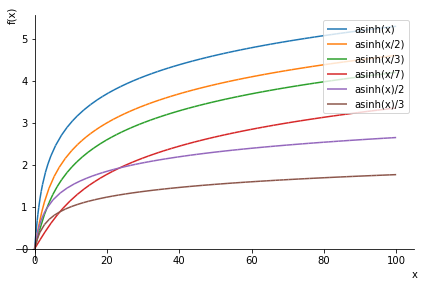

In [4]:
x, k = sp.symbols('x k')

p = sp.plot(show=False, legend=True)
c = 0

for kk in [1, 2, 3, 7]:
    f = sp.asinh(x / k)
    pp = sp.plot(f.subs({k: kk}), (x, 0, 100), show=False, line_color=f'C{c}')
    # this should not be zero wtf, I must be using sympy wrongly
    print(sp.limit(f / sp.log(x), x, +sp.oo))
    p.extend(pp)
    c += 1

for kk in [2, 3]:
    f = sp.asinh(x) / k
    pp = sp.plot(f.subs({k: kk}), (x, 0, 100), show=False, line_color=f'C{c}')
    print(sp.limit(f / sp.log(x), x, +sp.oo).subs({k: 0}))
    p.extend(pp)
    c += 1
    
p.legend = True
p.show()

# No transform

In [5]:
from data2 import CellDataset

d = {'expression': False, 'center': False, 'ome': True, 'mask': True}
ds = CellDataset('train', d)

KeyboardInterrupt: 

too slow

checking that flatten and reshape don't mix stuff but vectorize dimensions following the same order, we will use this soon to compute the quantiles

In [23]:
import torch
aa = torch.rand(1, 12, 7)
a = torch.stack([aa] * 5, dim=3)
mask = (aa > 0.5)
mask_f = mask.flatten()
b = a.reshape(-1, 5)[mask_f, :]
assert (b > 0.5).all()
print(a.shape)
print(mask.shape)

import torch
aa = torch.rand(1, 12, 7)
a = torch.stack([aa] * 5, dim=0)
mask = (aa > 0.5)
mask_f = mask.flatten()
b = a.reshape(5, -1)[:, mask_f]
assert (b > 0.5).all()
print(a.shape)
print(mask.shape)

torch.Size([1, 12, 7, 5])
torch.Size([1, 12, 7])
torch.Size([5, 1, 12, 7])
torch.Size([1, 12, 7])


let's make a rought estimate: per channel means of quantiles computed for each image. So 39 numbers in total

In [5]:
from tqdm import tqdm
from numba import jit
from torch.utils.data import DataLoader
import torch

q = 0.95
n_channels = ds[0][0].shape[-1]
quantiles = []

d = {'expression': False, 'center': False, 'ome': True, 'mask': True}
ds = CellDataset('train', d)
loader = DataLoader(ds, batch_size=1024, num_workers=16)
j = 0
for l in tqdm(loader):
    x = l[0]
    masks = l[1]
    x = x.reshape(-1, n_channels).cuda()
    masks = masks.flatten() 
#     print(torch.sum(masks))
    # tile and column_stack are not in torch 1.7.0
#     masks = torch.stack([masks] * n_channels).permute(1, 0)
    masks = masks.cuda().bool()
#     print(x.shape)
#     print(masks.shape)
    x = x[masks, :]
#     print(x.shape)
#     break
    a = torch.quantile(x, q=q, axis=0)
    quantiles.append(a.reshape(1, -1))
    j += 1
#     if j > 10:
#         break

100%|██████████| 437/437 [03:48<00:00,  1.91it/s]


torch.Size([437, 39])


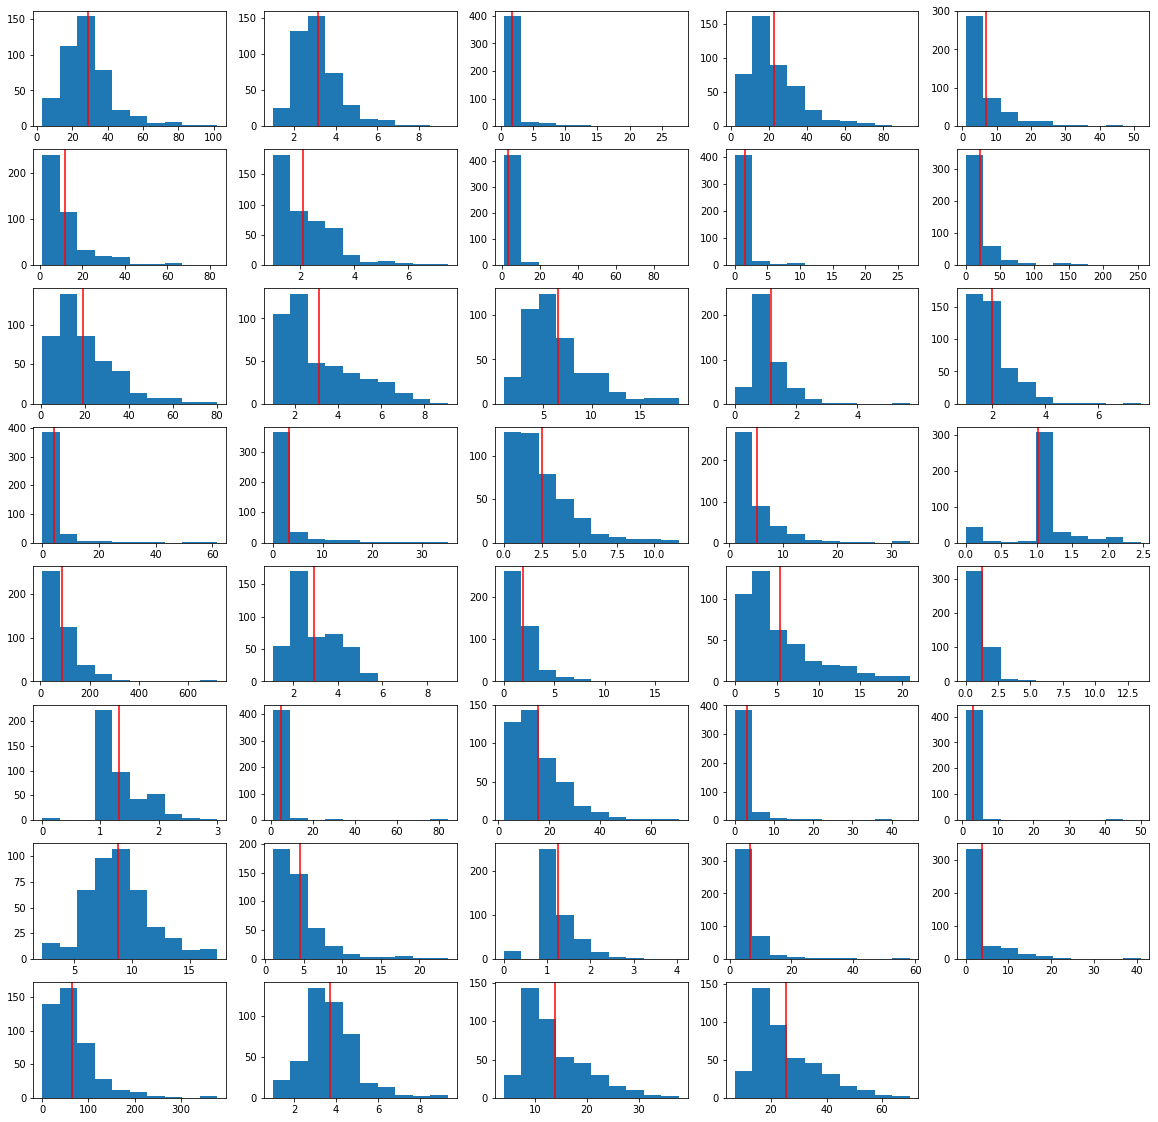

In [8]:
qq = torch.cat(quantiles, dim=0)
print(qq.shape)
means_of_quantiles = []
axes = plt.subplots(8, 5, figsize=(20, 20))[1].flatten()
for i, ax in enumerate(axes):
    if i == 39:
        ax.axis('off')
    else:
        x = qq[:, i].cpu().numpy()
        m = np.mean(x)
        means_of_quantiles.append(m)
        ax.hist(x)
        ax.axvline(x=m, c='r')

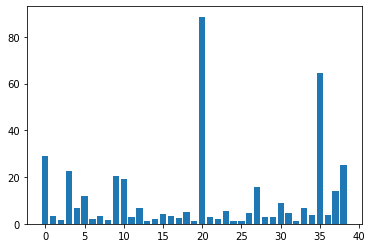

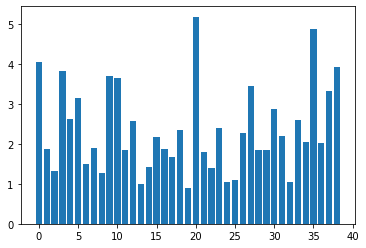

tensor([4.0549, 1.8684, 1.3117, 3.8141, 2.6172, 3.1571, 1.4984, 1.8866, 1.2621,
        3.7035, 3.6496, 1.8566, 2.5784, 0.9939, 1.4314, 2.1803, 1.8672, 1.6674,
        2.3555, 0.8917, 5.1779, 1.8002, 1.4042, 2.3873, 1.0509, 1.0892, 2.2708,
        3.4417, 1.8348, 1.8449, 2.8699, 2.2071, 1.0464, 2.5855, 2.0384, 4.8609,
        2.0277, 3.3281, 3.9273], dtype=torch.float64)


In [57]:
m = torch.tensor(means_of_quantiles).numpy()
plt.bar(np.arange(39), m)
plt.show()
arcsinh_quantiles = np.arcsinh(m)
plt.bar(np.arange(39), arcsinh_quantiles)
plt.show()
arcsinh_quantiles = torch.tensor(arcsinh_quantiles)
print(arcsinh_quantiles)

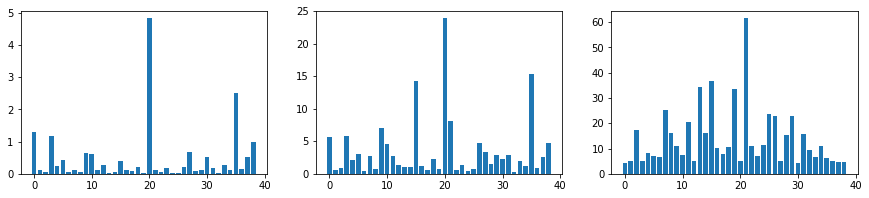

In [22]:
raw_data_mean = np.array([1.29137214, 0.12204645, 0.04746121, 1.17126412, 0.24452078,
       0.427998  , 0.07071735, 0.11199224, 0.04566163, 0.63347302,
       0.62917786, 0.13072797, 0.27373635, 0.02843522, 0.06192851,
       0.38788928, 0.11424681, 0.07840189, 0.2078604 , 0.02232897,
       4.8215692 , 0.13145834, 0.05435668, 0.17872389, 0.0315007 ,
       0.03429091, 0.20750708, 0.6714512 , 0.09881951, 0.12434302,
       0.51898777, 0.18728622, 0.03190125, 0.28144336, 0.11512508,
       2.50877083, 0.16205379, 0.52616125, 0.99683675])
raw_data_std = np.sqrt(np.array([3.17532575e+01, 3.66818966e-01, 6.65207711e-01, 3.33794102e+01,
       4.22485386e+00, 9.36283163e+00, 2.23369604e-01, 7.86815906e+00,
       5.32690521e-01, 4.84695307e+01, 2.08140218e+01, 7.09183370e+00,
       1.92951659e+00, 9.45509177e-01, 9.75673669e-01, 2.01367976e+02,
       1.37284794e+00, 3.73569237e-01, 4.87192135e+00, 5.64851603e-01,
       5.69273662e+02, 6.52422796e+01, 3.68515530e-01, 1.66068873e+00,
       1.29575157e-01, 6.50012842e-01, 2.25449424e+01, 1.09436277e+01,
       2.24749223e+00, 8.06681989e+00, 5.34230461e+00, 8.48350188e+00,
       9.04868194e-02, 3.58260224e+00, 1.58120290e+00, 2.32770610e+02,
       6.65773423e-01, 6.49080885e+00, 2.20182966e+01]))

axes = plt.subplots(1, 3, figsize=(15, 3))[1].flatten()
axes[0].bar(np.arange(39), raw_data_mean)
axes[1].bar(np.arange(39), raw_data_std)
axes[2].bar(np.arange(39), raw_data_std / raw_data_mean)
plt.show()

# arcsinh transform

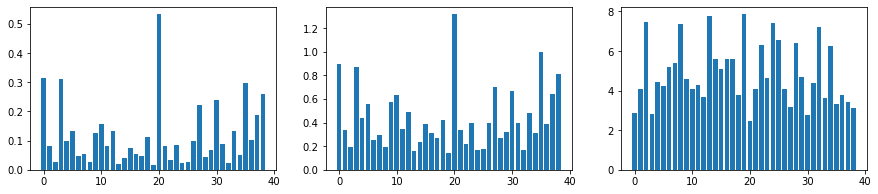

In [23]:
asinh_data_mean = np.array([0.3128328 , 0.08154685, 0.02617499, 0.31149776, 0.10011313,
       0.13143819, 0.04897958, 0.05522078, 0.02628855, 0.12524123,
       0.15552816, 0.08004793, 0.13349437, 0.02045013, 0.04155505,
       0.07637688, 0.05526352, 0.04818857, 0.11221485, 0.01779799,
       0.53215206, 0.08219107, 0.03510931, 0.08550659, 0.02237169,
       0.02657647, 0.09854327, 0.22031476, 0.04274541, 0.06778383,
       0.24079644, 0.09004467, 0.0234197 , 0.13312621, 0.04914724,
       0.29719813, 0.10172928, 0.18843424, 0.25893724])
asinh_data_std = np.sqrt(np.array([0.81152901, 0.11195328, 0.03844969, 0.76020458, 0.19636732,
       0.30648388, 0.06448294, 0.08879372, 0.03747649, 0.32956727,
       0.40133228, 0.11878445, 0.24177647, 0.02510913, 0.05398327,
       0.15110854, 0.09525968, 0.07278724, 0.17972434, 0.01950939,
       1.73329118, 0.11334923, 0.04934192, 0.15689578, 0.02762272,
       0.03045641, 0.16039316, 0.49438282, 0.07485281, 0.10151964,
       0.45035213, 0.15424273, 0.02854364, 0.23177609, 0.09494518,
       0.98995058, 0.14861627, 0.41785507, 0.66190155]))

axes = plt.subplots(1, 3, figsize=(15, 3))[1].flatten()
axes[0].bar(np.arange(39), asinh_data_mean)
axes[1].bar(np.arange(39), asinh_data_std)
axes[2].bar(np.arange(39), asinh_data_std / asinh_data_mean)
plt.show()

## Plotting the transformed dataset

In [47]:
from torch.utils.data import Dataset
from data2 import CellDataset
import torchvision.transforms.functional as TF
import random
from torch import nn

COOL_CHANNELS = np.arange(39) #[0, 10, 20]

class PadByOne:
    def __call__(self, image):
        return F.pad(image, pad=[0, 1, 0, 1], mode='constant', value=0)


class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)


class RGBCells(Dataset):
    def __init__(self, split, augment=False, aggressive_rotation=False):
        assert not (augment is False and aggressive_rotation is True)
        d = {'expression': False, 'center': False, 'ome': True, 'mask': True}
        self.ds = CellDataset(split, d)
        self.augment = augment
        self.aggressive_rotation = aggressive_rotation
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            PadByOne()
        ])
        self.augment_transform = transforms.Compose([
            MyRotationTransform(angles=[90, 180, 270]) if not self.aggressive_rotation else transforms.RandomApply(
                nn.ModuleList([transforms.RandomRotation(degrees=360)]),
                p=0.6
            ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])
#         self.normalize = ome_normalization()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, item):
        x = self.ds[item][0]
        if len(self.ds[item]) == 2:
            mask = self.ds[item][1]
            mask = self.transform(mask)
            if self.augment:
                state = torch.get_rng_state()
                mask = self.augment_transform(mask)
            mask = mask.float()
        elif len(self.ds[item]) == 1:
            mask = None
        else:
            raise ValueError()
        x = self.transform(x)
        if self.augment:
            torch.set_rng_state(state)
            x = self.augment_transform(x)
        x = torch.asinh(x)
        x = x[COOL_CHANNELS, :, :]
        x = x.permute(1, 2, 0)
#         x = (x - self.normalize.mean) / self.normalize.std
        x = x / arcsinh_quantiles[COOL_CHANNELS]
        x = x.permute(2, 0, 1)
        x = x.float()
        return x, mask

# Plotting cells

## no transform

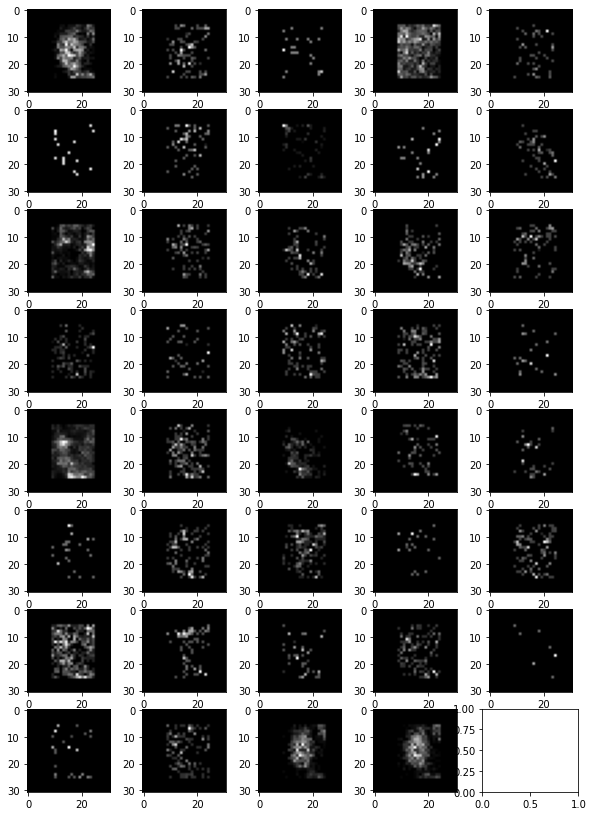

In [54]:
import matplotlib
from data2 import CellDataset

d = {'expression': False, 'center': False, 'ome': True, 'mask': False}
ds = CellDataset('train', d)
cell_k = 10000
x = ds[cell_k][0]
# plt.imshow(x)
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(x[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))

## transform and dividing by quantile

(32, 32, 39)


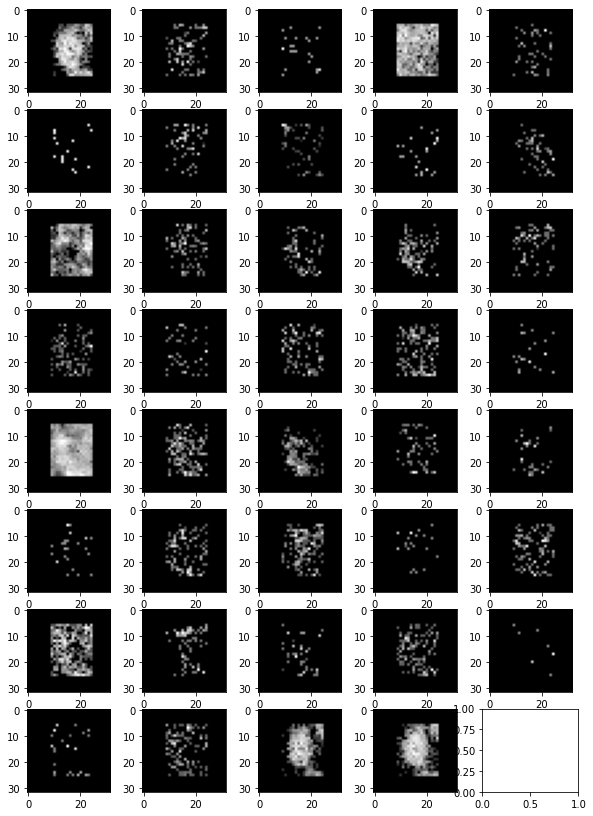

In [55]:
import matplotlib

ds = RGBCells('train')

cell_k = 10000
x = ds[cell_k][0].permute(1, 2, 0).numpy()
print(x.shape)
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(x[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))

## transform, no scaling, no centering

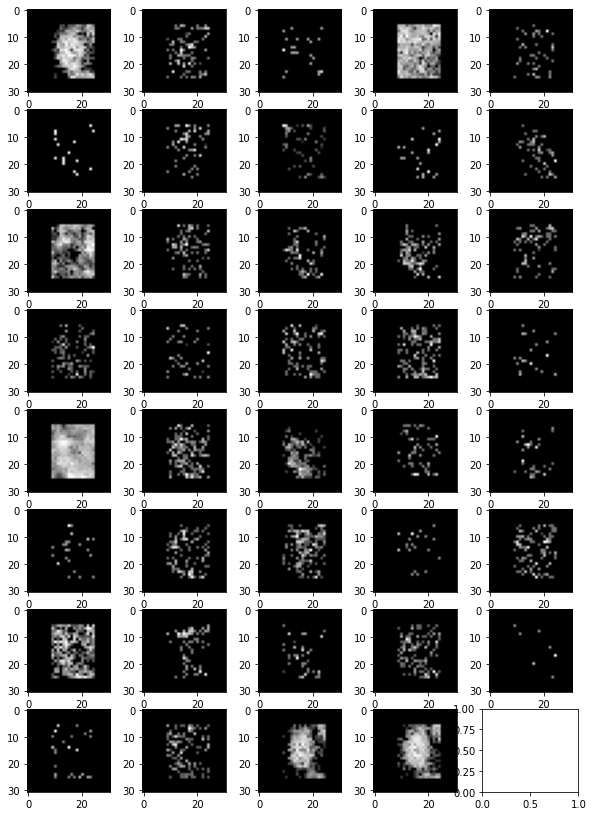

In [13]:
y = np.arcsinh(x)
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(y[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))

## transform, scaling, centering

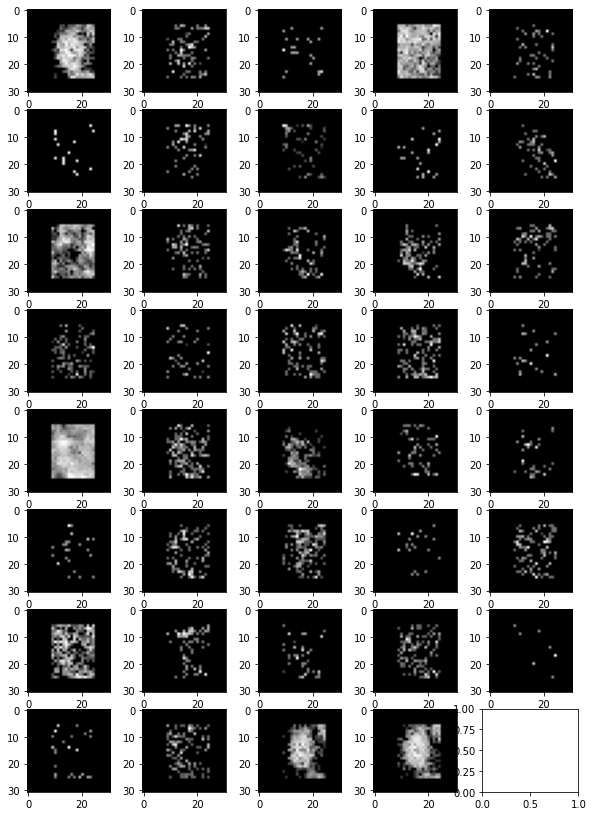

In [16]:
mean = np.array([0.3128328 , 0.08154685, 0.02617499, 0.31149776, 0.10011313,
       0.13143819, 0.04897958, 0.05522078, 0.02628855, 0.12524123,
       0.15552816, 0.08004793, 0.13349437, 0.02045013, 0.04155505,
       0.07637688, 0.05526352, 0.04818857, 0.11221485, 0.01779799,
       0.53215206, 0.08219107, 0.03510931, 0.08550659, 0.02237169,
       0.02657647, 0.09854327, 0.22031476, 0.04274541, 0.06778383,
       0.24079644, 0.09004467, 0.0234197 , 0.13312621, 0.04914724,
       0.29719813, 0.10172928, 0.18843424, 0.25893724])
std = np.sqrt(np.array([0.81152901, 0.11195328, 0.03844969, 0.76020458, 0.19636732,
       0.30648388, 0.06448294, 0.08879372, 0.03747649, 0.32956727,
       0.40133228, 0.11878445, 0.24177647, 0.02510913, 0.05398327,
       0.15110854, 0.09525968, 0.07278724, 0.17972434, 0.01950939,
       1.73329118, 0.11334923, 0.04934192, 0.15689578, 0.02762272,
       0.03045641, 0.16039316, 0.49438282, 0.07485281, 0.10151964,
       0.45035213, 0.15424273, 0.02854364, 0.23177609, 0.09494518,
       0.98995058, 0.14861627, 0.41785507, 0.66190155]))


z = y.copy()
z = (z - mean) / std
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(z[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))

Maybe I should use quantiles to perform scaling and centering, or maybe just scaling, no centering. Otherwise the background is different between channels. But maybe this is not a problem since they are quite similar, and among cells the background, which is always 0, is identical

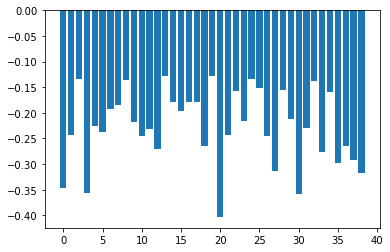

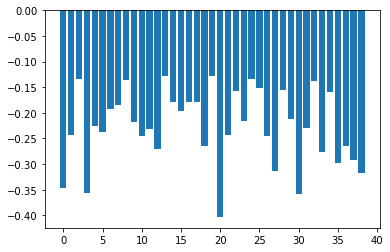

In [38]:
plt.bar(np.arange(39), z[0, 0, :])
plt.show()

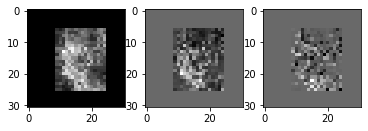

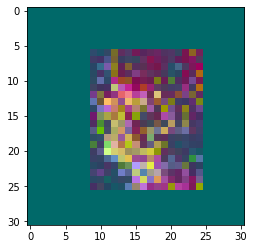

In [39]:
from sklearn.decomposition import PCA
reducer = PCA(3)
pca = z.reshape((-1, 39))
pca = reducer.fit_transform(pca)
a = np.min(pca, axis=0)
b = np.max(pca, axis=0)
pca = (pca - a) / (b - a)
pca.shape = [z.shape[0], z.shape[1], 3]
axes = plt.subplots(1, 3, figsize=(3 * 2, 1 * 1.8))[1].flatten()
for i in range(3):
    axes[i].imshow(pca[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))
plt.show()
plt.imshow(pca)
plt.show()

## per cell PCA

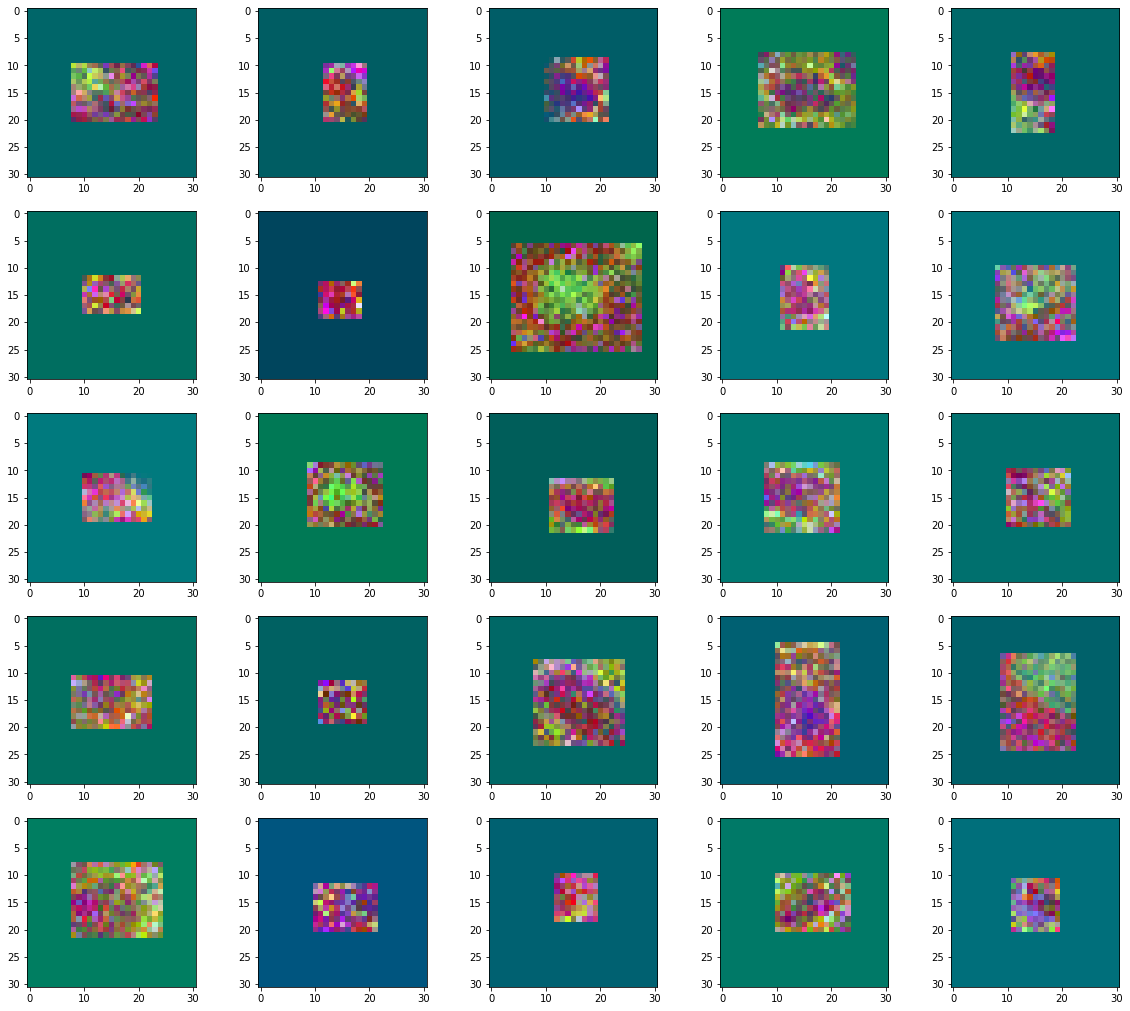

In [55]:
axes = plt.subplots(5, 5, figsize=(5 * 4, 5 * 3.6))[1].flatten()
for i in range(25):
    k = 1000 + i
    x = ds[k][0]
    z = (np.arcsinh(x) - mean) / std
    reducer = PCA(3)
    pca = z.reshape((-1, 39))
    pca = reducer.fit_transform(pca)
    a = np.min(pca, axis=0)
    b = np.max(pca, axis=0)
    pca = (pca - a) / (b - a)
    pca.shape = [z.shape[0], z.shape[1], 3]
    axes[i].imshow(pca)

## global PCA

[ -1.89303345 -10.03051639  -6.08467324] [22.14650635 11.09995976 11.53956775]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[-3.43603055e-15  1.09276271e-01  5.56130924e-02]
[-3.43603055e-15  1.48393526e-01  8.36480371e-02]
[-3.43603055e-15  5.19993307e-02  8.04801786e-02]
[-3.43603055e-15  1.83130184e-01  1.13612194e-01]
[-3.43603055e-15  2.37638986e-01  8.72671466e-02]
[-3.43603055e-15  1.63315212e-01  7.08135735e-03]
[-3.43603055e-15  7.76435354e-02  7.29376253e-04]
[-3.43603055e-15  1.18914614e-01  8.95929545e-02]
[0.86345927 1.00000104 0.89918159]
[-3.43603055e-15  1.53196648e-01  1.18216606e-01]
[-3.43603055e-15  1.08866244e-01  4.28192696e-02]
[-3.43603055e-15  1.53753647e-01  4.88656262e-02]
[-3.43603055e-15  7.29302189e-02  3.08632581e-02]
[1.         0.81472952 0.81172019]
[-3.43603055e-15  1.43492720e-01  1.13381951e-01]
[-3.43603055e-15  1.43492720e-01  9.51821018e-02]
[-3.43603055e-15  1.80698450e-01  4.39530669e-02]
[-3.43603055e-15 -8.08591556e-05  5.92350005e-02]
[-3.43603055e-15  9.44070541e-02  1.47725832e-01]
[-3.43603055e-15  1.36606353e-01  2.98987016e-02]
[-3.43603055e-15  1.21975248e-

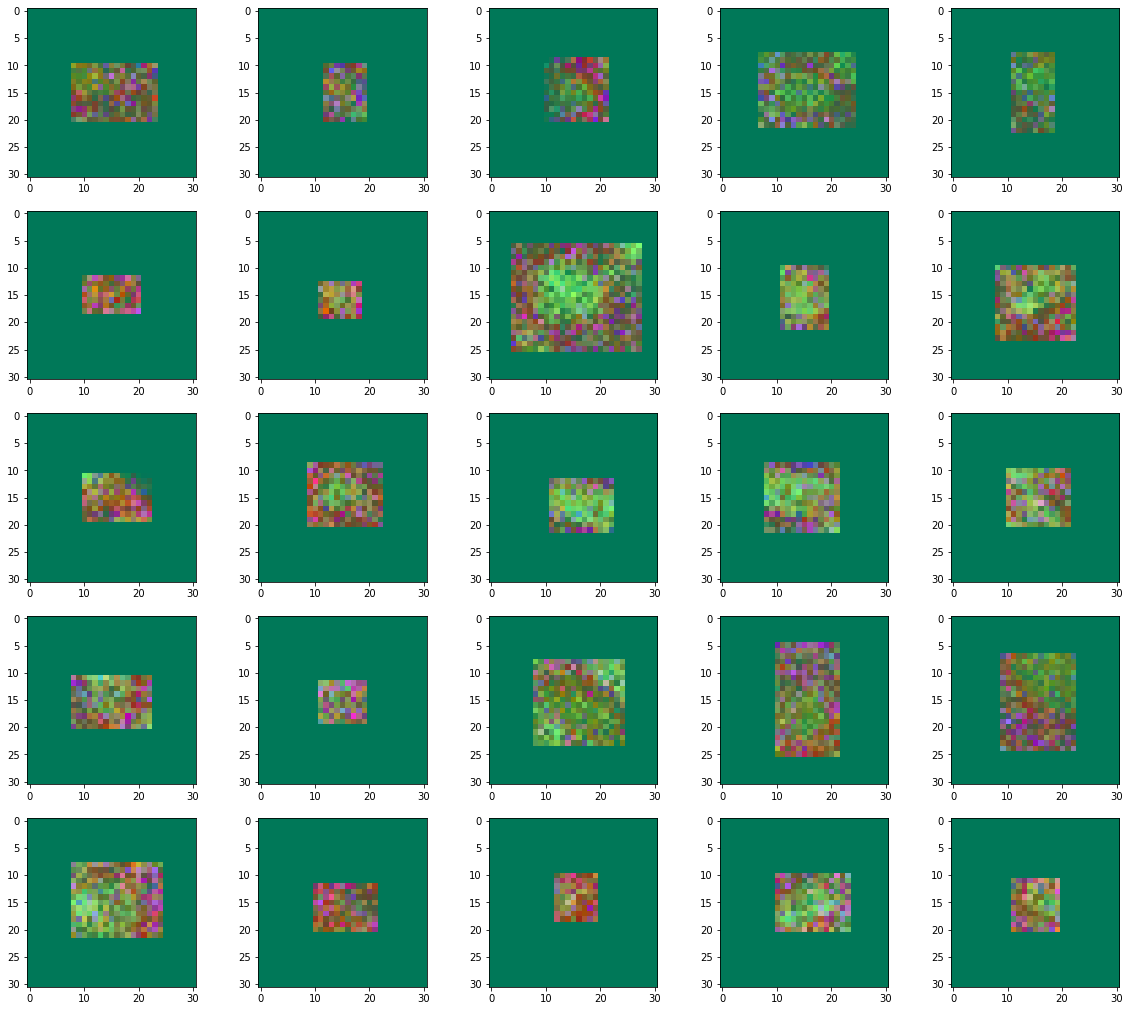

In [56]:
l = []
for i in range(25):
    k = 1000 + i
    x = ds[k][0]
    z = (np.arcsinh(x) - mean) / std
    z = z.reshape((-1, 39))
    l.append(z)
w = np.concatenate(l, axis=0)
reducer = PCA(3)
global_pca = reducer.fit_transform(w)
a = np.min(global_pca, axis=0)
b = np.max(global_pca, axis=0)
print(a, b)    
axes = plt.subplots(5, 5, figsize=(5 * 4, 5 * 3.6))[1].flatten()
for i in range(25):
    k = 1000 + i
    x = ds[k][0]
    z = (np.arcsinh(x) - mean) / std
    pca = z.reshape((-1, 39))
    pca = reducer.transform(pca)
    pca = (pca - a) / (b - a)
    if any(pca.min(0) < 0):
        print(pca.min(0))
    if any(pca.max(0) > 1):
        print(pca.max(0))
    pca.shape = [z.shape[0], z.shape[1], 3]
    axes[i].imshow(pca)

## transform, scaling, centering, augmentation, no aggressive rotation

torch.Size([39, 32, 32])
<class 'torch.Tensor'>


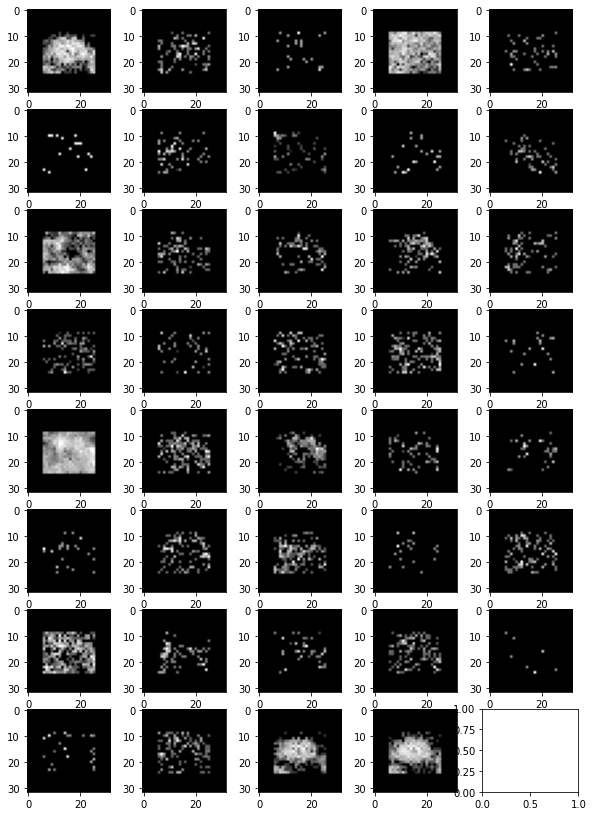

In [89]:
import matplotlib

ds = RGBCells('train', augment=True)
cell_k = 10000
x = ds[cell_k]
print(x.shape)
print(type(x))
x = x.permute(1, 2, 0)
import matplotlib.pyplot as plt
# plt.imshow(x)
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(x[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))

## transform, scaling, centering, augmentation, aggressive rotation

torch.Size([39, 32, 32])
<class 'torch.Tensor'>


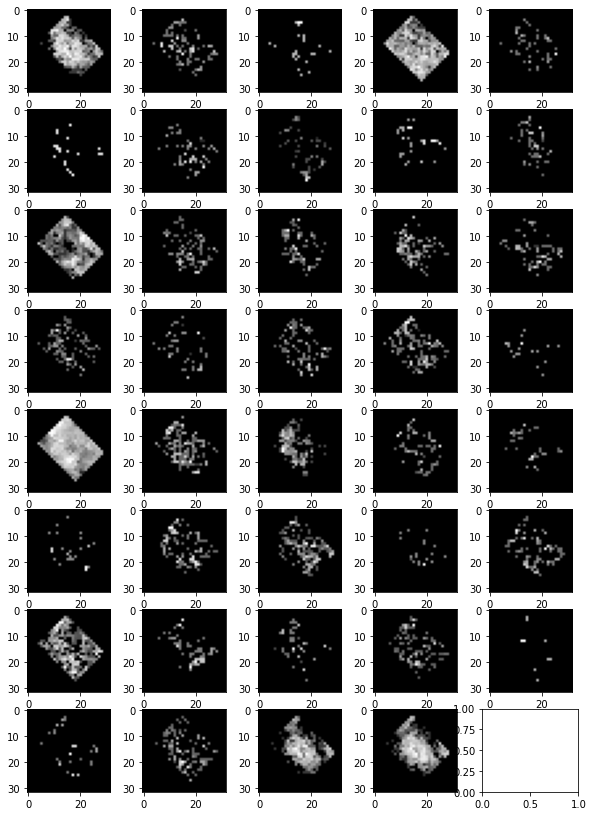

In [97]:
ds = RGBCells('train', augment=True, aggressive_rotation=True)
cell_k = 10000
x = ds[cell_k]
print(x.shape)
print(type(x))
x = x.permute(1, 2, 0)
import matplotlib.pyplot as plt
# plt.imshow(x)
axes = plt.subplots(8, 5, figsize=(5 * 2, 8 * 1.8))[1].flatten()
for i in range(39):
    axes[i].imshow(x[:, :, i], cmap=matplotlib.cm.get_cmap('gray'))